# PQTrees
#### Lev. G 2020

![Wikipedia - example](./docs/images/wiki_pqtree.png)

### Project mostly based on the work described at:
* __Finding All Common Intervals of k Permutations:__ `docs/articles/Finding All Common Intervals of k Permutations.pdf`

* __Gene Proximity Analysis Across Whole Genomes via PQ Trees__: `docs/articles/Gene Proximity Analysis Across Whole Genomes via PQ Trees (2005) OrenWeimann.pdf`

## The project:
### This notebook is devided into a few subpartts as follows:

i. Common intervals   
ii. PQTrees    
iii. PQTrees extensions    
iv. Apendix   

Each part will provide an explanatiion, an implementation and further remarks

## Common Intervals 

### Glossary

#### 1. Common Intervals

For `k` permutation over the same alephabet, w.l.o.g over `[0..x]` and first permutation `p0` is `[0..x]`,
Common intervals are sub intervals of `p0` (for example `[1..3]`) tha appear together in all the permutation.

Trivial common intervals are all the singltons (because the permutations are over the same alphabet) - 
`[0,0]` ... `[x,x]`,   
and the whole permutation `[0,x]`

__Example:__   
For permutations `(0, 1, 2, 3, 4) ; 4, 3, 0, 2, 1)` the non trivial common intervals are:
`{ [1,2], [3,4], [0,2], [0,3] }`

#### 2. Irreducible intervals 
For `k` permutation as in `1.` irreducible intervals are a sub set of the common intervals set, 
that follow:  

Each interval that is not composable from any other intervals

__Composoble:__ An interval is said to be composble in the case there are some other intervals that overlap with at leasr 1 character and compose the said interval, for ex. composing `[2,4]` with `[3,5]` produces `[2,5]`

__Example:__ For athe following group of intervals:   
`{[1, 2], [1, 3], [1, 8], [1, 9], [2, 3], [4, 5], [4, 6], [4, 7], [4, 8], [4, 9], [5, 6] }`

The subset of irreducible intervlas is:   
`{[1, 2], [1, 8], [2, 3], [4, 5], [4, 7], [4, 8], [4, 9], [5, 6]}`


### Algorithms

In order to find all the common intervals, first a trivial algorithm was used - then amore eficient one was devised.

#### 1. Trivial algorithm

```python
for size in [1, ..., len(permutations[0])]:
    for w in sliding_window(permutations[0], size):
        char_set = set(w)
        if all(find_char_set(p, char_set) for p in permutations[1:]):
            common_intervals.add(w)

```

In [1]:
from pqtrees import trivial_common_k

permutations =  ((0, 1, 2, 3, 4), (4, 3, 0, 2, 1))
trivial_common_k(*permutations)

[CI[1, 2], CI[3, 4], CI[0, 2], CI[0, 3], CI[0, 4]]

#### 2. Optimized Algorithm

The optimized algorithm before searching a char_set in some pemutation - will index all the subsets of such permutation with the length of char_set - reducing the runtime of subsequent searched to `O(1)`.

Index generation is done lazily (the index is updated only upon first search of a certain length), to eliminate not needed proccessing when working with big anounts of permutations (more than 20-30).

The algorithm structure is very similar to `1.` but with indexing changes:

```python
for size in [1, ..., len(permutations[0])]:
    index = {}
    for w in sliding_window(permutations[0], size):
        char_set = set(w)
        if char_set_in_others(permutations[1:], char_set, index):
            common_intervals.add(w)

def char_set_in_others(others, char_set, index):
    for other in others:
        if other not in index:
            index_perm(index, other, len(char_set)
        if char_set not in index[other]:
            return False
    return True
                                      
def index_perm(index, perm, length):
    for w in sliding_window(perm, length):
        index[perm].add(set(w))
```

In [2]:
from pqtrees import common_k_indexed

permutations =  ((0, 1, 2, 3, 4), (4, 3, 0, 2, 1))
common_k_indexed(*permutations)

[CI[1, 2], CI[3, 4], CI[0, 2], CI[0, 3], CI[0, 4]]

#### 3. Benchmark
We want to measure the improvement of the second alg.
Thus we will run randomized examples on a large amount of long permutations and measure the times.

In [3]:
import random
from pprint import pprint
from pqtrees import time_runtime

REPEAT_TEST_TIMES = 150
LENGTH = 100
NUM_PERMS = 100

algs = [trivial_common_k, common_k_indexed]
names = [alg.__name__ for alg in algs]
total_times = {name: 0 for name in names}


for _ in range(REPEAT_TEST_TIMES):

    sig_a = list(range(LENGTH))
    other_perms = [list(sig_a) for _ in range(NUM_PERMS - 1)]
    for p in other_perms:
        random.shuffle(p)

    t_others = map(tuple, other_perms)

    for alg, alg_name in zip(algs, names):
        _, cur_rt = time_runtime(lambda: alg(sig_a, *t_others))
        total_times[alg_name] += cur_rt

print("\nRuntimes:")
pprint(total_times)



Runtimes:
{'common_k_indexed': 1.0003891130000122, 'trivial_common_k': 57.063777956}


## PQTree
![Wikipedia - example](./docs/images/wiki_pqtree.png)

### Glossary

#### PQtree
A rooted, ordered, tree consisting of __P__ nodes and __Q__ nodes, which represents a number of string, recursivly built from the __P__ and __Q__ rules bellow.

#### PNode (mnemonic - permutation node)
A __P__ node yield the strings that consist of all the permutations of it's children (leafs / inner nodes).

In the example tree above, the PNode yields: `(2,3,4), (2,4,3), (3,2,4), (3,4,2), (4,3,2), (4,3,2)`

#### QNode
A __Q__ node yield the strings that consits of it's children in their order, and in their reverse order.

In the example tree above, the Qnode yields: `(1, yield(P), 5), (5, yield(P), 1)`

#### Full example
If we combine both yields, as described aobve, the full yield of the example tree is:
`12345, 12435, 13245, 13425, 14235, 14325, 52341, 52431, 53241, 53421, 54231, 54321`

#### Parentheses representation
PQtrees could also be represented as parentheses where:
1. QNode is serrounded by `[ ]` brackets
2. PNode is sorrounded by `( )` brackets

Thus our example tree could be represented as: `[1 (2 3 4) 5]`

### Construction Algorithm

The construction algorithm is consisted of few steps.
For give `P = {p1, ... , pk}` permutation of `(1...x)` the steps are:

1. Compute the common intervals set of P - as described in the first section
2. Compute the irreducible intervals set (a strait forward alg. - description not attached)
3. From the irreducible intervals set - compue a data stracture called `S`
4. From `S` - construct the PQTree

#### Construction of  `S` from the set of irreducible intervals

![S data structure](./docs/images/s_data_stracture.png)

The structure as depicted above is a sort of the irreduvible intervals set by nesting level.

__Nesting Level:__ nesting level of an interval, is the amount of other intervals that include said interval (as sub interval)

As we can see in the example `[4,5]` has nesting level of 4 - because its included in `[4,7], [4,8], [1,8], [4,9]`

The alg. to perform such sorting is pretty strait forward:
1. sort the interval by size from large to small
2. For each interval in above order check if its included in the larger intervals, if so its nesting level is +1 of the first interval that includes it (the smallest one).

Because we're not dealing with hige amounts of intervals above alg. is sufficently efficient, although there are faster ways to compute the `S` data structure.

#### Construction of a PQTree from a  `S` data stracture

When constructing the tree we will iterate over `S` in a bottom order from left to right:

* If nestigLevel(x) > nestingLevel(y) then x shows up in the iteration before y
* If left(a) < left(b)  the a shows up in the iteration befoe b

While iteration over `S` we have 3 kind of cases for each interval:
![S iter pic](./docs/images/s_iter_cases_pic.png)

![S iter description](./docs/images/s_iter_description.png)


##### Case A
Trivial intervals in `S` - will be represented as leafs in the produced PQtree

##### Case B
* Will be represented as a QNode in the tree
* In the example (1,3)
* QNodes' children will be:
    * A child representing the intersection - in the example - 2
    * A child representing the items that are only in the left interval - 1
    * A child representing the items that are only in the right inreval - 3

We can see the _orange_ Qnode that will be produced from the highlited intervals:
![S iter description](./docs/images/qnode_example.png)

##### Case C
An intervals that is not a part of interval chain - will be represented as a PNode in the final tree

Note: PNode with 2 children - will be converted to a QNode as we can see happed to the _green_ interval:

![S iter description](./docs/images/pnode_example1.png)

##### Case C - Example with PNode produced ???????

### PQTree construction code example
We will show demonstrate the construction of the tree that is in the first Example

In [4]:
from pqtrees import common_k_indexed_with_singletons, ReduceIntervals, IntervalHierarchy, PQTreeBuilder

perms = [(0, 1, 2, 3, 4), (0, 1, 3, 2, 4), (0, 2, 1, 3, 4),
         (0, 2, 3, 1, 4), (0, 3, 1, 2, 4), (0, 3, 2, 1, 4),
         (4, 1, 2, 3, 0), (4, 1, 3, 2, 0), (4, 2, 1, 3, 0),
         (4, 2, 3, 1, 0), (4, 3, 1, 2, 0), (4, 3, 2, 1, 0)]

print

common_intervals = common_k_indexed_with_singletons(*perms)
ir_intervals = ReduceIntervals.reduce(common_intervals)

s = IntervalHierarchy.from_irreducible_intervals(ir_intervals)
pqtree = PQTreeBuilder._from_s(s)

# Which is equivalent to:
perms_starting_1 = list(map(lambda perm: tuple(x + 1 for x in perm), perms))
pqtree = PQTreeBuilder.from_perms(perms_starting_1)
pqtree

PQ<[1 (2 3 4) 5]>

We can check the parenthesis representation and inspect the frontier:

In [5]:
pqtree.to_parens()

'[1 (2 3 4) 5]'

In [6]:
list(pqtree.frontier())

['12345',
 '52341',
 '12435',
 '52431',
 '13245',
 '53241',
 '13425',
 '53421',
 '14235',
 '54231',
 '14325',
 '54321']

And visualzie the tree:

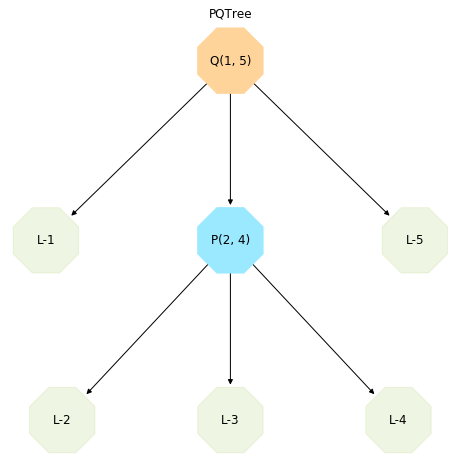

In [7]:
from pqtrees import PQTreeVisualizer

PQTreeVisualizer.show(pqtree)

We can also produce a Json representation for integration with other tools

In [8]:
print(pqtree.to_json(pretty=True, ommit_multi_info=True))

{
  "approx_front_size": 12,
  "root": {
    "type": "QNode",
    "children": [
      {
        "type": "LEAF",
        "char": "1"
      },
      {
        "type": "PNode",
        "children": [
          {
            "type": "LEAF",
            "char": "2"
          },
          {
            "type": "LEAF",
            "char": "3"
          },
          {
            "type": "LEAF",
            "char": "4"
          }
        ]
      },
      {
        "type": "LEAF",
        "char": "5"
      }
    ]
  }
}


## PQtree extensions

### PQtree with Multi Characters

### PQTree with multiple occuraces of characters

### PQtree with multiple occuraces - context optimization
This enhancement is still a work in progress and has known examples that brake that will be presented

## Further work to be done